# Assignment

**This guide compares a fine-tuned [SegFormer](https://arxiv.org/abs/2105.15203) with the 'The devil is in the labels' from [Yin et al.](https://arxiv.org/abs/2202.02002). The dataset used is the [CMP Facade Database](https://cmp.felk.cvut.cz/~tylecr1/facade/). The used framework is Huggingface [`🤗 transformers`](https://huggingface.co/transformers), an open-source library that offers easy-to-use implementations of state-of-the-art models. The models are made available on the HuggingFace hub, the largest open-source catalog of models and datasets.**

Semantic segmentation is the task of classifying each pixel in an image to a corresponding category. It has a wide range of use cases in fields such as medical imaging, autonomous driving, robotics, etc. For the facade dataset we are interested to identify and classify the following classes: facade, molding, cornice, pillar, window, door, sill, blind, balcony, shop, deco, and background.

Semantic segmentation is a type of image classification that involves dividing an image into different regions and assigning each region a class label. In 2014, [Long et al.](https://arxiv.org/abs/1411.4038) published a fundamental paper that used convolutional neural networks for semantic segmentation. More recently, the use of Transformers for image classification has become popular (such as [ViT](https://huggingface.co/blog/fine-tune-vit)). Transformers are also being used for semantic segmentation, leading to improved performance in this task. SegFormer is a state-of-the-art model for semantic segmentation introduced in 2021. It has a hierarchical Transformer encoder that does not rely on positional encodings and a simple multi-layer perceptron decoder. SegFormer has demonstrated excellent performance on several widely used datasets. In this case, we will use SegFormer to classify sidewalk images for use in a pizza delivery robot.

Recently, Yin et al. introduced a novel approach to semantic segmentation that achieves state-of-the-art performance in a zero-shot setting. This means that the model is able to achieve results equivalent to supervised methods on various semantic segmentation datasets, without being trained on these datasets. The approach involves replacing class labels with vector-valued embeddings of short paragraphs that describe the class. This allows for the merging of multiple datasets with different class labels and semantics, resulting in a merged dataset of over 2 million images. The resulting model achieves performance equal to state-of-the-art supervised methods on 7 benchmark datasets, and even outperforms methods when fine-tuned on standard semantic segmentation datasets. Therefore, we will use as a backbone the pre-trained encoder from Yin et al. and fine-tune a classification head for the CMP facade dataset with very few labels.

The following illustration is taken from the paper `The devil is in the labels: Semantic segmentation from sentences` ([Yin et al.](https://arxiv.org/abs/2202.02002)):

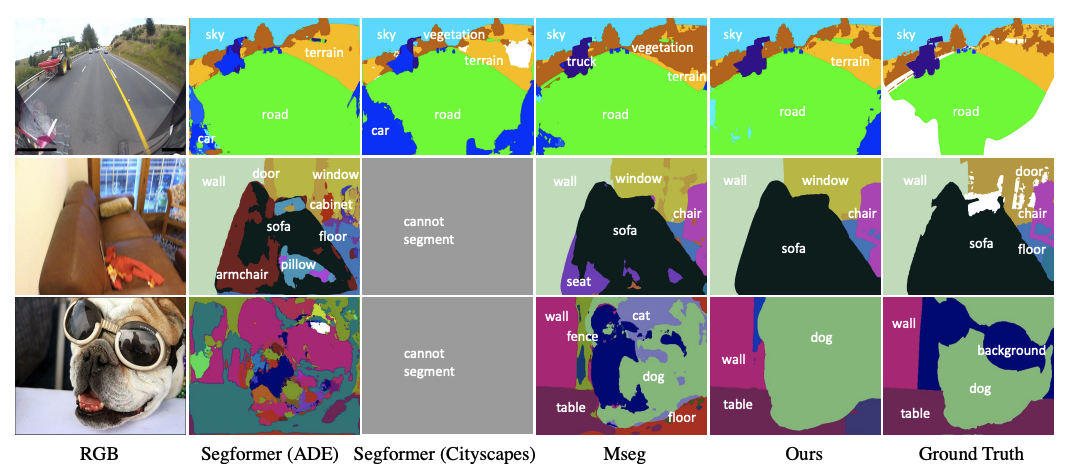

Let's get started by logging in to HuggingFace.

In [2]:
# ignore unnecessary warning
import warnings
warnings.filterwarnings("ignore")

from huggingface_hub import notebook_login

hf_username = "Xpitfire"
notebook_login()

Login successful
Your token has been saved to /home/ubuntu/.huggingface/token


# 1. Load a dataset

In order to train a semantic segmentation model, we need a dataset with semantic segmentation labels. One option is to use the `CMP Facade Database`, which is specifically designed for semantic segmentation tasks. The dataset format has been specifically adjusted to work with the HuggingFace `Dataset` format.

In [116]:
import numpy as np
from dataset.load_cmp import CMPDataset

# helper variables for ids and labels
id2label = CMPDataset.id2label
label2id = {v: k for k, v in id2label.items()}
unique_colors = CMPDataset.unique_colors
num_labels = CMPDataset.num_labels

In [117]:
from datasets import load_dataset
ds = load_dataset('Xpitfire/cmp_facade')

train_ds = ds['train']
eval_ds = ds['eval']
test_ds = ds['test']

Using custom data configuration Xpitfire--cmp_facade-fe115472bdc1edc1
Reusing dataset parquet (/home/ubuntu/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-fe115472bdc1edc1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

## Feature extractor & data augmentation

A SegFormer model expects the input to be of a certain shape. To transform our training data to match the expected shape, we can use `SegFormerFeatureExtractor`. Furthermore, we'll use a *transform*, which will only prepare a batch of data when that data is actually used (on-the-fly). This way, we can start training without waiting for further data preprocessing.

In our transform, we'll also define some data augmentations to make our model more resilient to different lighting conditions. We'll use the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) function from `torchvision` to randomly change the brightness, contrast, saturation, and hue of the images in the batch.

We could implement also other augmentations, such as horizontal flipping or random cropping. However, those need to be applied in alignment for both image and segmentation mask.

In [118]:
import torch
import torchvision.transforms as T
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
crop = T.RandomResizedCrop(512)
flip = T.RandomHorizontalFlip(0.5)

def train_transforms(example_batch):
    # color jettering
    images = [jitter(x) for x in example_batch['pixel_values']]
    
    # random crop 
    iamges = [i for i in images]
    labels = [x for x in example_batch['label']]
    
    inputs = feature_extractor(images, labels)
    for i in range(len(inputs['pixel_values'])):
        # concatenate images
        image = torch.from_numpy(inputs['pixel_values'][i])
        target = torch.from_numpy(inputs['labels'][i]).view(1, *image.shape[1:]).expand_as(image)
        both_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)), 0)
        # Apply the transformations to both images simultaneously:
        transformed_images = crop(both_images)
        transformed_images = flip(both_images)
        # Get the transformed images:
        inputs['pixel_values'][i] = transformed_images[0].numpy()
        inputs['labels'][i] = transformed_images[1][0].to(torch.int64).numpy()
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

# Set transforms
train_ds.set_transform(train_transforms)
eval_ds.set_transform(val_transforms)

### Visualizing our Data

The following function displays the image with the segemtnation mask overlayed using `matplotlib`. The function is then called with an image and mask from `cmp_ds_train` Dataset and the resulting image is displayed.

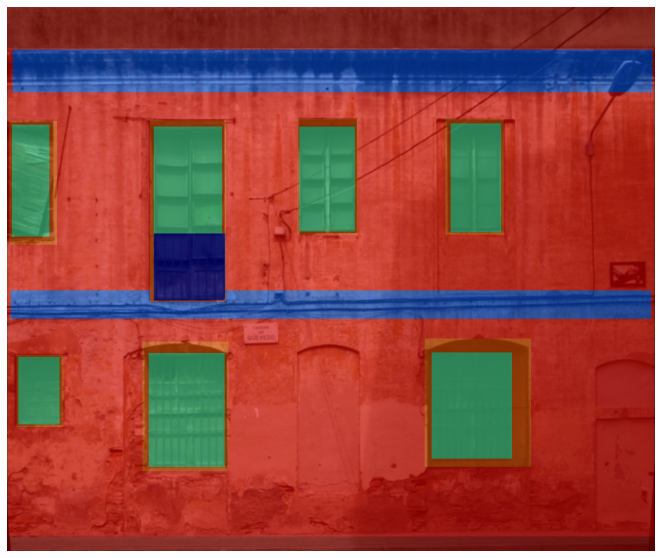

In [119]:
import matplotlib.pyplot as plt

def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    palette = np.array(unique_colors)
    for label, color in enumerate(palette):
        color_seg[mask == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# visualize the image + segmentation mask
visualize_seg_mask(
    np.array(test_ds[0]['pixel_values']),
    np.array(test_ds[0]['label'])
)

# 3. Fine-tune a Model

## Load the model to fine-tune

The SegFormer authors define 5 models with increasing sizes: B0 to B5. Yin et al. also provides pre-trained checkpoints in their repo, however, only for the B5 version of the SegFormer (see [Repository Link](https://github.com/irfanICMLL/SSIW/tree/master)).

In this notebook, we'll provide code to load the smallest SegFormer model (B0), pre-trained on ImageNet-1k, which is only about 14MB in size, and code to load the pre-trained SegFromer model (B5) from Yin et al.

### [Option 1]: SegFormer (B5) from Yin et al.

In [21]:
import torch
from utils.segformer import get_configured_segformer

seg_model = get_configured_segformer(num_labels, criterion=None, load_imagenet_model=False)
seg_model.eval()
seg_model = torch.nn.DataParallel(seg_model)
ckpt_path = 'models/segformer_7data.pth'
checkpoint = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt_filter = {k: v for k, v in checkpoint.items() if 'criterion.0.criterion.weight' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items() if 'module.segmodel.head' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items() if 'module.segmodel.auxi_net' not in k}
seg_model.load_state_dict(ckpt_filter, strict=False);

In [22]:
from typing import Optional, Union, Tuple
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import SegformerPreTrainedModel, SegformerConfig, SegformerDecodeHead
from transformers.modeling_outputs import SemanticSegmenterOutput

class CustomSegformerForSemanticSegmentation(SegformerPreTrainedModel):
    def __init__(self, config, seg_model):
        super().__init__(config)
        self.segformer = seg_model
        self.decode_head = SegformerDecodeHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SemanticSegmenterOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        outputs = self.segformer(
            pixel_values,
        )
        logits = self.decode_head(outputs)

        loss = None
        if labels is not None:
            if not self.config.num_labels > 1:
                raise ValueError("The number of labels should be greater than one")
            else:
                # upsample logits to the images' original size
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                loss_fct = CrossEntropyLoss(ignore_index=self.config.semantic_loss_ignore_index)
                loss = loss_fct(upsampled_logits, labels)

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )

configuration = SegformerConfig(subnorm_type='batch',
                                semantic_loss_ignore_index=0,
                                hidden_sizes=[64, 128, 320, 512],
                                decoder_hidden_size=768,
                                num_labels=num_labels)
model = CustomSegformerForSemanticSegmentation(configuration, 
                                               seg_model.module.segmodel.encoder).cuda()

### [Option 2]: SegFormer (B0) Baseline

In [120]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model = model.cuda()

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_mean', 'decode_head.line

## Set up the Trainer

To fine-tune the model on our data, we'll use Hugging Face's [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). In order to use a Trainer, we need to set up the training configuration, and an evalutation metric.

First, we'll set up the [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [128]:
from transformers import TrainingArguments

epochs = 50
lr = 0.0006
batch_size = 12

hub_model_id = "segformer-finetuned-segments-cmp-facade"

training_args = TrainingArguments(
    "segformer-finetuned-segments-cmp-facade-outputs-transforms",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
    optim='adamw_torch',
    remove_unused_columns=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the mean Intersection over Union (mIoU), directly accessible in the `datasets` library (see [here](https://huggingface.co/metrics/mean_iou)). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [129]:
import torch
import numpy as np
from torch import nn
from datasets import load_metric

metric = load_metric("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(predictions=pred_labels, references=labels, 
                                 num_labels=num_labels, 
                                 ignore_index=0,
                                 reduce_labels=False)
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()[1:]
        return metrics

Finally, we can instantiate a `Trainer` object.

In [130]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = None
        outputs = model(**inputs)
        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        return (loss, outputs) if return_outputs else loss
    
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
)

/publicwork/dinu/workspace/SSIW/segformer-finetuned-segments-cmp-facade-outputs-transforms is already a clone of https://huggingface.co/Xpitfire/segformer-finetuned-segments-cmp-facade. Make sure you pull the latest changes with `repo.git_pull()`.


Now that our trainer is set up, training is as simple as calling the `train` function. We don't need to worry about managing our GPU(s), the trainer will take care of that.

In [131]:
trainer.train()

***** Running training *****
  Num examples = 378
  Num Epochs = 50
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 1600
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
20,1.232800,1.232170,0.193817,0.276410,0.584318,"[0.46588897486611575, 0.4794379279754499, 0.47516306513696516, 0.0, 0.21479697731322273, 0.1468532929608522, 0.15399766900533918, 0.0, 0.0, 0.34140124873016997, 0.0, 0.04826207870683769]","[0.6484014402727478, 0.7268698138428387, 0.7396621827345261, 0.0, 0.314071721025026, 0.16580774409430243, 0.18421110637031626, 0.0, 0.0, 0.48692030347962645, 0.0, 0.05097341298090315]"
40,1.115800,1.134006,0.250337,0.358491,0.605046,"[0.5176739126303989, 0.47108775141725884, 0.49329266238923963, 0.003963836494345551, 0.26672845921223864, 0.2701529378697397, 0.31332750965950773, 0.04532147556410988, 0.011623004855842847, 0.3621998398780441, 0.0, 0.24866980358175594]","[0.8000948297521079, 0.6337371473364622, 0.6603131057495936, 0.003965968313890952, 0.34629573729708046, 0.3680114248799625, 0.4865078902745655, 0.04561502007369462, 0.0118031463226356, 0.5511836320859765, 0.0, 0.3943689580818554]"
60,0.977100,1.099430,0.283501,0.390974,0.617956,"[0.5113476068813879, 0.49334140108090285, 0.4746839761440892, 0.040214174001835405, 0.31186037529280675, 0.31181019822943934, 0.35578648191496853, 0.20097078621392386, 0.08022661461990363, 0.38374995642386217, 0.0005073985432159898, 0.23750983005264706]","[0.7168020611741474, 0.7219130768570321, 0.5340207091634352, 0.0431815185182615, 0.45474233550172505, 0.5430138746239189, 0.469268628306114, 0.217241626853214, 0.09605778018331367, 0.5683827928074056, 0.0005080911993094857, 0.3265519411515883]"
80,0.856600,1.086197,0.264045,0.377809,0.630886,"[0.5101947204251175, 0.5344538212406682, 0.49436541874132667, 0.018884843581445522, 0.270377214768106, 0.28449876963719384, 0.32160160861987425, 0.086283029811171, 0.11932598089180631, 0.39498832385101396, 0.0009054175167701066, 0.13266404817912572]","[0.6129614268456303, 0.7713753471720866, 0.7994049832227069, 0.019437755463182074, 0.5688067632752372, 0.4619781591716599, 0.3827566445038881, 0.08782710157707345, 0.15580996069314926, 0.5327405741537456, 0.0009059939457566733, 0.1397020438061634]"
100,0.785400,1.000472,0.327815,0.440976,0.647628,"[0.5451244129938286, 0.5178187584431643, 0.5318888189962618, 0.14778251064896017, 0.3169269253463421, 0.2626134690690619, 0.39125714035001896, 0.3081966042250305, 0.12383697911511432, 0.3977603328560864, 0.04942253722870921, 0.34114884162827647]","[0.7394164167070112, 0.7120692919670155, 0.65725755249271, 0.17395090943157923, 0.46355298851110294, 0.31981316619425926, 0.6107480292025965, 0.35138126519456003, 0.1554151176100015, 0.5705962518273815, 0.05702864593695384, 0.4804842819854117]"
120,0.727500,1.005542,0.340712,0.465826,0.650022,"[0.5331521735997542, 0.5305308321791462, 0.5588320252288795, 0.16697584226263984, 0.3296551780182928, 0.28048869107094193, 0.35449032046775947, 0.34190939733724723, 0.16527723782325413, 0.39484470653333187, 0.0880505368099854, 0.3443421783020718]","[0.6790541517825218, 0.7248947508922547, 0.702760127940592, 0.22049812284439385, 0.49308863123902213, 0.336202860575091, 0.6458925386011786, 0.40734546148068546, 0.2508473598750699, 0.5798344703996796, 0.12197249573784942, 0.4275176163504493]"
140,0.762000,1.009922,0.335780,0.463078,0.647653,"[0.5210483275809908, 0.5385459417489167, 0.519285461653176, 0.19235183880209375, 0.3408901260438495, 0.3345069902216156, 0.36090171027181106, 0.33539228285452394, 0.1422865859237117, 0.3681340241516971, 0.023384620855608634, 0.35263641309339605]","[0.6388404926271997, 0.7725403351834625, 0.6020424381762673, 0.21688954275126474, 0.5520221552773765, 0.4518525508185774, 0.6697900807527053, 0.46810120099302377, 0.1897420654286044, 0.45603045018648025, 0.024152696709344286, 0.5149349510456322]"
160,0.754300,0.996490,0.350763,0.472209,0.655320,"[0.5029245432853789, 0.5438264868522664, 0.5504928848830769, 0.20921503460100002, 0.3484194245550177, 0.34286066341367244, 0.4044913460614946, 0.3442055933600121, 0

***** Running Evaluation *****
  Num examples = 114
  Batch size = 12
Trainer is attempting to log a value of "[0.46588897486611575, 0.4794379279754499, 0.47516306513696516, 0.0, 0.21479697731322273, 0.1468532929608522, 0.15399766900533918, 0.0, 0.0, 0.34140124873016997, 0.0, 0.04826207870683769]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6484014402727478, 0.7268698138428387, 0.7396621827345261, 0.0, 0.314071721025026, 0.16580774409430243, 0.18421110637031626, 0.0, 0.0, 0.48692030347962645, 0.0, 0.05097341298090315]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to segformer-finetuned-segments-cmp-facade-outputs-transforms/checkpoint-20
Configuration saved in segformer-finetuned

TrainOutput(global_step=1600, training_loss=0.419273029640317, metrics={'train_runtime': 14177.5959, 'train_samples_per_second': 1.333, 'train_steps_per_second': 0.113, 'total_flos': 3.31530475143168e+17, 'train_loss': 0.419273029640317, 'epoch': 50.0})

When we're done with training, we can push our fine-tuned model and the feature extractor to the Hugging Face hub.

This will also automatically create a model card with our results. We'll supply some extra information in `kwargs` to make the model card more complete.

In [ ]:
hf_dataset_identifier = 'cmp-facade'

kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

feature_extractor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

# 4. Inference

Now comes the exciting part, using our fine-tuned model! In this section, we'll show how you can load your model from the hub and use it for inference. 

However, you can also try out your model directly on the Hugging Face Hub, thanks to the cool widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html). If you pushed your model to the hub in the previous step, you should see an inference widget on your model page. You can add default examples to the widget by defining example image URLs in your model card. See [this model card](https://huggingface.co/segments-tobias/segformer-b0-finetuned-segments-sidewalk/blob/main/README.md) as an example.

## Use the model from the hub

We'll first load the model from the hub using `SegformerForSemanticSegmentation.from_pretrained()`.



In [9]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")


In [11]:
hub_model_id = "segformer-finetuned-segments-cmp-facade"
model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

Next, we'll load an image from our test dataset.

To segment this test image, we first need to prepare the image using the feature extractor. Then we forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [12]:
#@title `def sidewalk_palette()`

def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

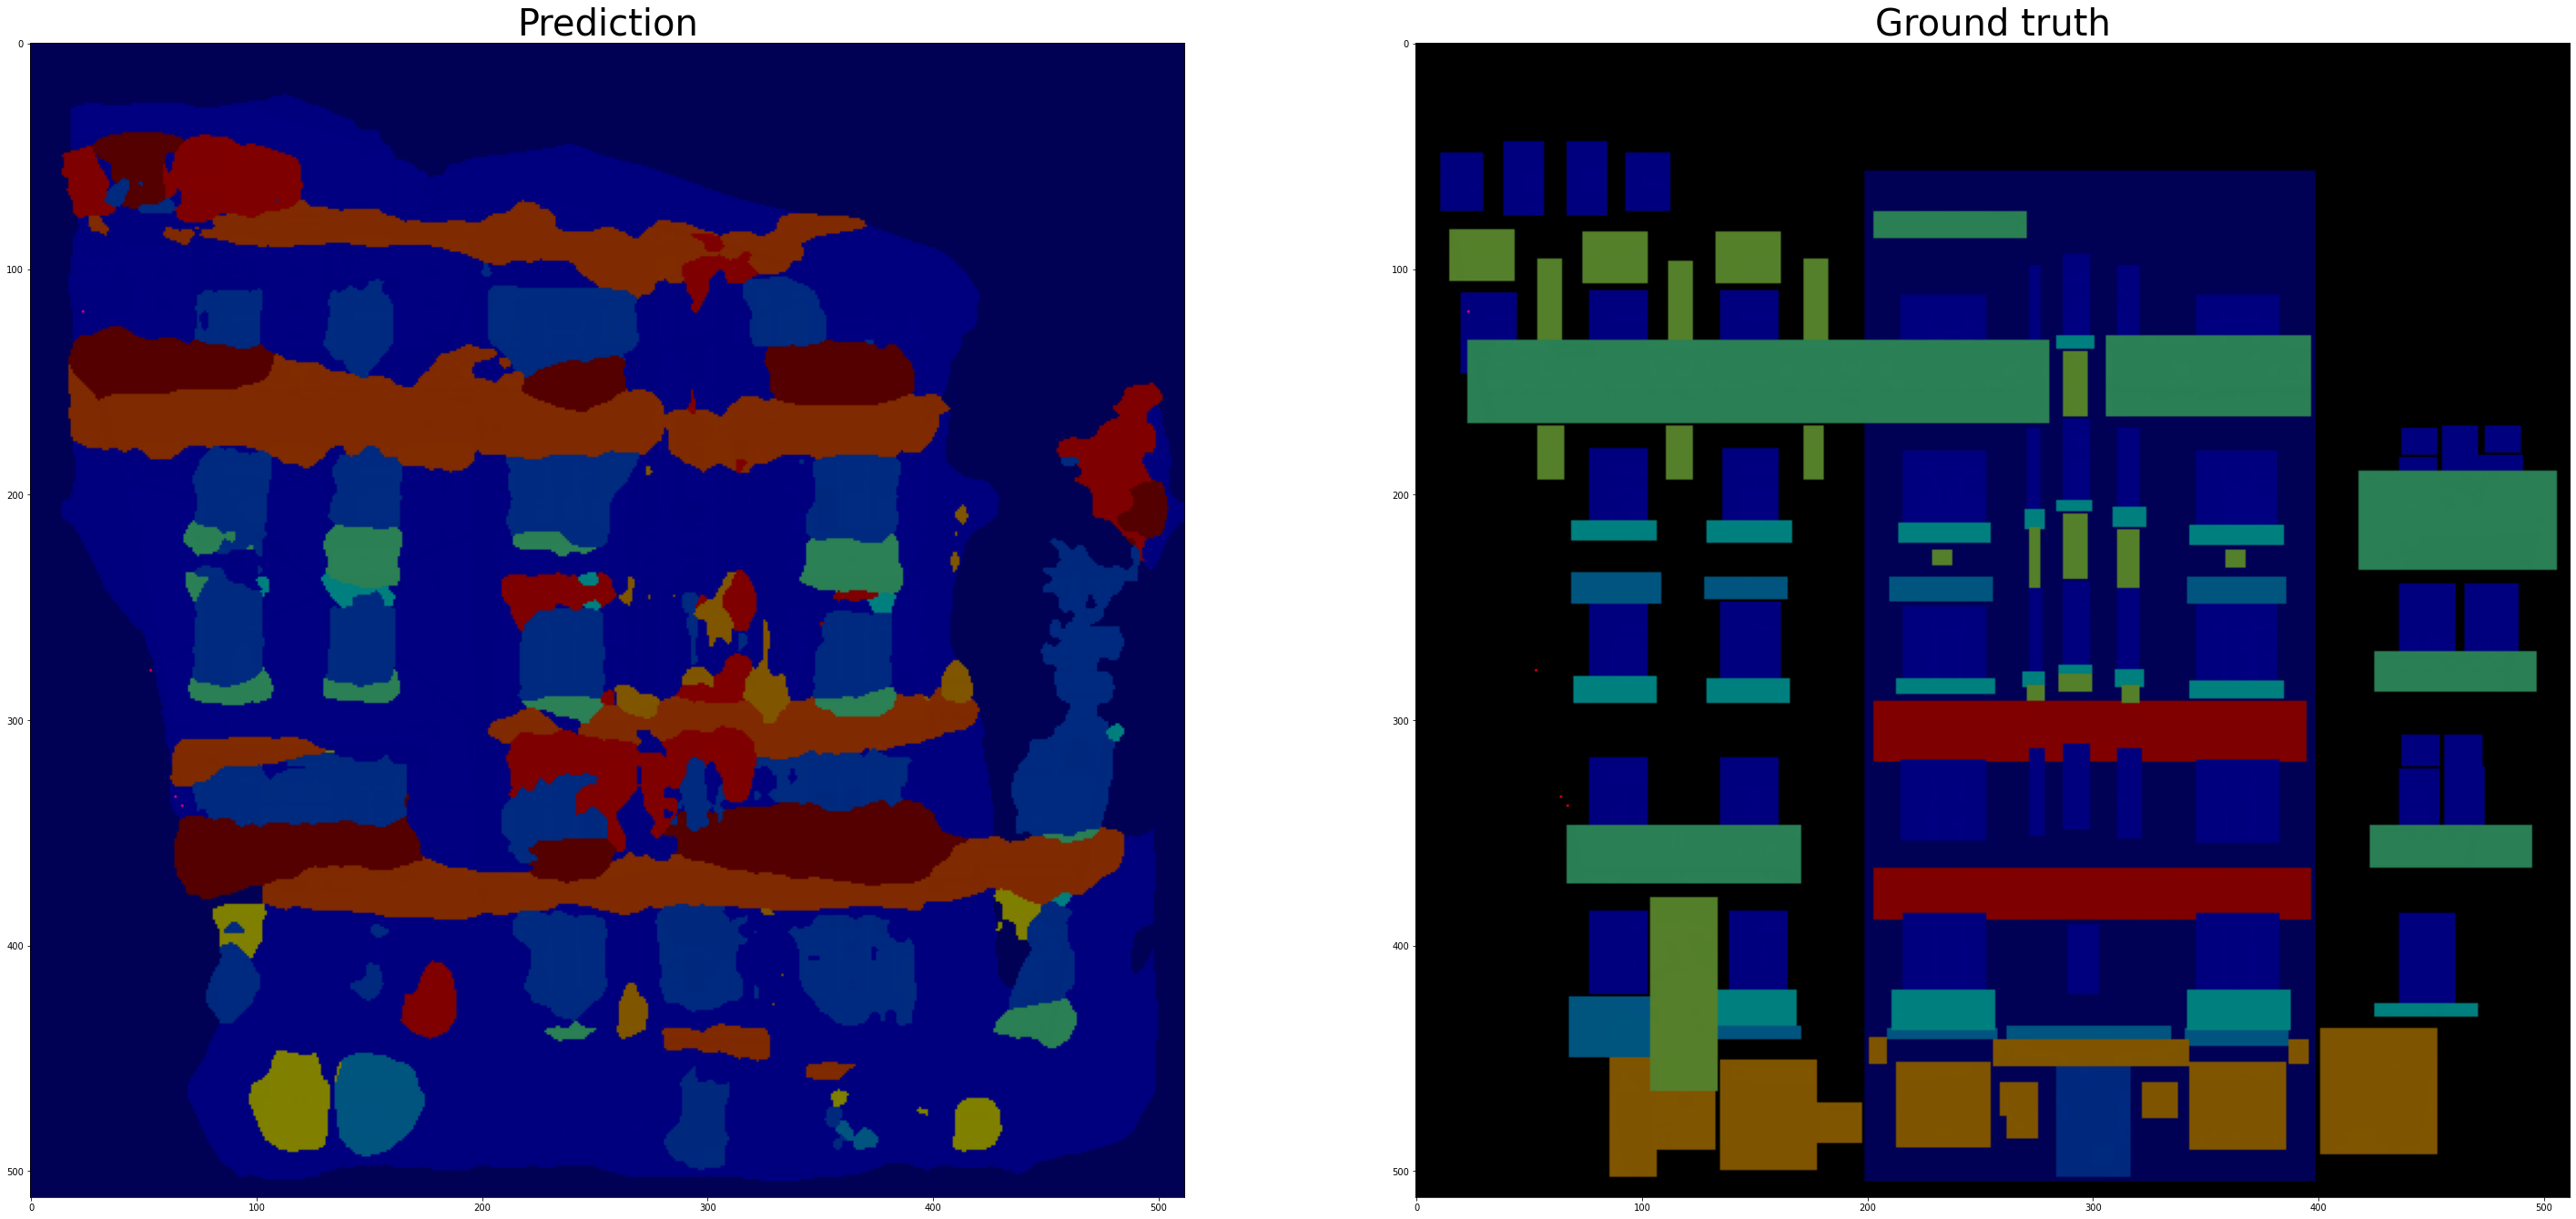

In [14]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

model = model.cpu()

img_idx = 5

image = eval_ds[img_idx]['pixel_values']
gt_seg = eval_ds[img_idx]['labels']

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.shape[1::], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

def get_seg_overlay(image, seg):
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(unique_colors)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img


pred_img = get_seg_overlay(image.transpose(1, 2, 0), pred_seg)
gt_img = get_seg_overlay(image.transpose(1, 2, 0), np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)

What do you think? Would you send our pizza delivery robot on the road with this segmentation information?

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. We can now also go train a larger SegFormer model, and see how it stacks up.

# 5. Conclusion

That's it! You now know how to create your own image segmentation dataset and how to use it to fine-tune a semantic segmentation model.

We introduced you to some useful tools along the way, such as:


*   [Segments.ai](https://segments.ai) for labeling your data
*   [🤗 datasets](https://huggingface.co/docs/datasets/) for creating and sharing a dataset
*   [🤗 transformers](https://huggingface.co/transformers) for easily fine-tuning a state-of-the-art segmentation model
*   [🤗 hub](https://huggingface.co/docs/hub/main) for sharing our dataset and model, and for creating an inference widget for our model


We hope you enjoyed this post and learned something. Feel free to share your own model with us on Twitter ([@TobiasCornille](https://twitter.com/tobiascornille), [@NielsRogge](https://twitter.com/nielsrogge), and [@huggingface](https://twitter.com/huggingface)).